# **Homework 3** 

## Data Loading

In [1]:
#mountig drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#importing various libraries 
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow_datasets.public_api as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import add
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
!gdown --id 1y2MhN3fc-ce9m3EsBf6xj8UUFaXB36bU
!mkdir -p /content/drive/MyDrive/Colab\ Notebooks
!mv NWPU-RESISC45.rar /content/drive/MyDrive/Colab\ Notebooks

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1y2MhN3fc-ce9m3EsBf6xj8UUFaXB36bU
To: /content/NWPU-RESISC45.rar
100% 424M/424M [00:01<00:00, 271MB/s]


In [4]:
!mkdir -p /root/tensorflow_datasets/downloads/manual
!cp /content/drive/MyDrive/Colab\ Notebooks/NWPU-RESISC45.rar .
!unrar x NWPU-RESISC45.rar /root/tensorflow_datasets/downloads/manual -idq -o+

In [5]:
#splitting the dataset into training, validation, and test sets
(train_ds, val_ds, test_ds), info_ds = tfds.load('resisc45', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [6]:
#separating test dataset to x and y components and adding to a list
test_numpy = tfds.as_numpy(test_ds)  # Convert `tf.data.Dataset` to Python generator

testX = []
testY = []

for ex in test_numpy:
  testX.append(ex[0])
  testY.append(ex[1])

In [7]:
#transforming list into array
testY = np.array(testY)
testX = np.array(testX)

In [8]:
#separating train dataset to x and y components and adding to a list
train_numpy = tfds.as_numpy(train_ds)  # Convert `tf.data.Dataset` to Python generator

trainX = []
trainY = []

for ex in train_numpy:
  trainX.append(ex[0])
  trainY.append(ex[1])

In [9]:
#transforming list into array
trainY = np.array(trainY)
trainX = np.array(trainX)

In [10]:
#separating test dataset to x and y components and adding to a list
val_numpy = tfds.as_numpy(val_ds)  # Convert `tf.data.Dataset` to Python generator

valX = []
valY = []

for ex in val_numpy:
  valX.append(ex[0])
  valY.append(ex[1])

In [11]:
#transforming list into array
valY = np.array(valY)
valX = np.array(valX)

In [12]:
#list of target names
feats = info_ds.features["label"].names

### Preproccesing the Data

The preprocessing of the training images is built into the varioius convolutional neural network architectures.

## Model Training and Tuning

### Sandwich CNN

In [ ]:
class SandwichCNN:
  def build(height, width, depth, classes, blocks, dropout = False, augment = False):
    model = Sequential()

    model.add(Rescaling(1./255, input_shape = (height, width, depth)))

    if augment:
      model.add(RandomFlip())
      model.add(RandomRotation(0.1))
      model.add(RandomZoom(0.1))

    for i in range(blocks):
      model.add(Conv2D(2 ** (blocks + 5), (3,3), padding = 'same'))
      model.add(Activation('relu'))

      model.add(MaxPooling2D((2,2)))
      
      if dropout: model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    return model



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 45)                8847405   
                                                        

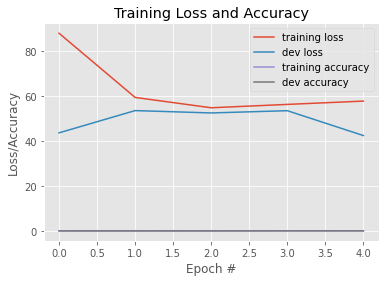

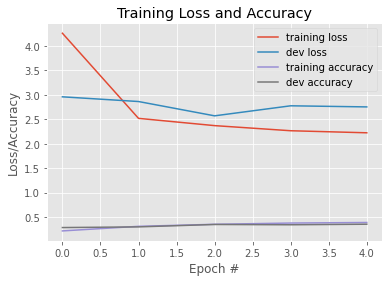

In [ ]:
dropout = 0.2
augment = True
maxEpochs = 5
batch_size = 32

for i in range(2):
  model = SandwichCNN.build(256,256,3,45,i, dropout=dropout, augment=augment)
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
  print(model.summary())
  H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = maxEpochs, batch_size = batch_size)

  # plot the training loss and accuracy
  plt.style.use("ggplot")
  plt.figure()

  plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
  plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
  plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
  plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

### MiniVGGNet

In [ ]:
class MiniVGGNet:
  def build(height, width, depth, classes):
    model = Sequential(name = 'MiniVGGNet')

    #rescaling layer to change image shape
    model.add(Rescaling(1./255, input_shape = (height, width, depth)))

    #data augmentation
    model.add(RandomFlip())
    model.add(RandomRotation(0.1))
    model.add(RandomZoom(0.1))
    
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (height, width, depth)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
   
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation('softmax'))

    return model

Model: "MiniVGGNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_20 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_20 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_20 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 conv2d_75 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_115 (Activation)  (None, 256, 256, 32)     0         
                                                        

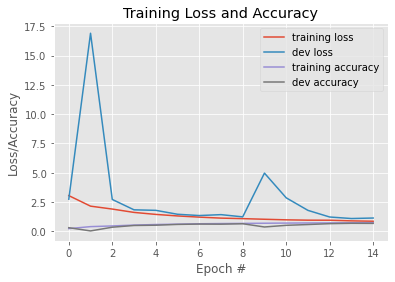

In [ ]:
maxEpochs = 15
batch_size = 32

model = MiniVGGNet.build(256,256,3,45)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(model.summary())
H = model.fit(train_dataset, validation_data = test_dataset, epochs = maxEpochs, batch_size = batch_size)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### AlexNet

In [13]:
class AlexNet:
    def build(height, width, depth, classes, lambda2 = 0.0002):
        model = Sequential(name = 'AlexNet')

        #rescaling layer to change image shape
        model.add(Rescaling(1./255, input_shape = (height, width, depth)))

        #data augmentation
        model.add(RandomFlip())
        model.add(RandomRotation(0.1))
        model.add(RandomZoom(0.1))
        
        model.add(Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, kernel_regularizer = l2(lambda2)))
        model.add(Activation('softmax'))
        
        return model

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 96)        34944     
                                                                 
 activation (Activation)     (None, 64, 64, 96)        0         
                                                           

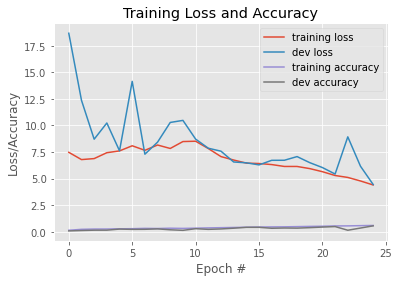

In [14]:
maxEpochs = 25
batch_size = 32

model = AlexNet.build(256,256,3,45)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(model.summary())
H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = maxEpochs, batch_size = batch_size)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### LeNet

In [13]:
class LeNet:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()

        #rescaling layer to change image shape
        model.add(Rescaling(1./255, input_shape = (height, width, depth)))

        #data augmentation
        model.add(RandomFlip())
        model.add(RandomRotation(0.1))
        model.add(RandomZoom(0.1))
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                        

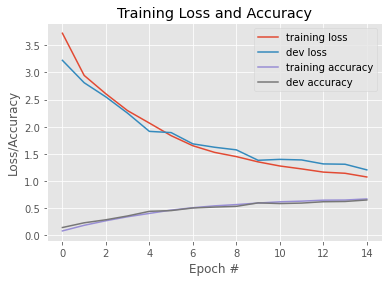

In [14]:
maxEpochs = 15
batch_size = 32

model = LeNet.build(256,256,3,45)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(model.summary())
H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = maxEpochs, batch_size = batch_size)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [16]:
model.save("model1")

### MiniGoogLeNet

In [15]:
class MiniGoogLeNet:
    def convolution_module(x, K, kX, kY, stride, channelsDim, padding="same"):
        # create a CONV -> BN -> RELU sequence
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = BatchNormalization(axis = channelsDim)(x)
        x = Activation('relu')(x)
        
        # return the output
        return x
    
    def inception_module(x, numberOf1x1Kernels, numberOf3x3Kernels, channelsDim):
        # define two "parallel" convolutions of size 1x1 and 3x3 concatenated across the channels dimension
        convolution_1x1 = MiniGoogLeNet.convolution_module(x, numberOf1x1Kernels, 1, 1, (1, 1), channelsDim)
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, numberOf3x3Kernels, 3, 3, (1, 1), channelsDim)
        x = concatenate([convolution_1x1, convolution_3x3], axis = channelsDim)
        
        return x
        
    def downsample_module(x, K, channelsDim):
        # define a CONV and POOL and then concatenate across the channels dimension
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, K, 3, 3, (2, 2), channelsDim, padding = 'valid')
        pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
        x = concatenate([convolution_3x3, pool], axis = channelsDim)
        
        return x
    
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        # define the model input and first CONV module
        inputs = Input(shape = inputShape)
        x = MiniGoogLeNet.convolution_module(inputs, 96, 3, 3, (1, 1), channelsDim)
        
        # two inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 80, channelsDim)
        
        # four inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 96, channelsDim)
        
        # two inception modules followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation('softmax')(x)
        
        # create a model
        model = Model(inputs, x, name='MiniGoogLeNet')
        
        # return the model
        return model

Epoch 1/15
788/788 [==============================] - 196s 242ms/step - loss: 2.5338 - accuracy: 0.3333 - val_loss: 2.6655 - val_accuracy: 0.3179
Epoch 2/15
788/788 [==============================] - 188s 238ms/step - loss: 1.6817 - accuracy: 0.5157 - val_loss: 1.9505 - val_accuracy: 0.4421
Epoch 3/15
788/788 [==============================] - 188s 238ms/step - loss: 1.3432 - accuracy: 0.6090 - val_loss: 1.8727 - val_accuracy: 0.4875
Epoch 4/15
788/788 [==============================] - 188s 238ms/step - loss: 1.1157 - accuracy: 0.6690 - val_loss: 1.6395 - val_accuracy: 0.5538
Epoch 5/15
788/788 [==============================] - 188s 238ms/step - loss: 0.9261 - accuracy: 0.7247 - val_loss: 1.5606 - val_accuracy: 0.5692
Epoch 6/15
788/788 [==============================] - 188s 238ms/step - loss: 0.7769 - accuracy: 0.7647 - val_loss: 1.3964 - val_accuracy: 0.6090
Epoch 7/15
788/788 [==============================] - 188s 238ms/step - loss: 0.6569 - accuracy: 0.7995 - val_loss: 1.3316 -

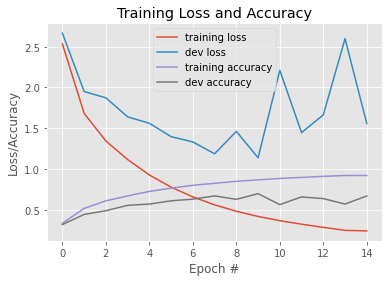

In [ ]:
maxEpochs = 15
batch_size = 32

model = MiniGoogLeNet.build(256,256,3,45)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
#print(model.summary())
H = model.fit(train_dataset, batch_size = batch_size, validation_data = test_dataset, epochs = maxEpochs)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### ResNet

In [ ]:
class ResNet:
    def residual_module(data, K, stride, channelsDim, reduce = False, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9):
        shortcut = data
        
        # 1x1 CONVs
        bn1 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act1)
        
        # 3x3 CONVs
        bn2 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = 'same', use_bias = False, kernel_regularizer = l2(reg))(act2)
        
        # 1x1 CONVs
        bn3 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv2)
        act3 = Activation('relu')(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act3)
        
        # if we reduce the spatial size, apply a CONV layer to the shortcut
        if reduce:
            shortcut = Conv2D(K, (1, 1), strides = stride, use_bias = False, kernel_regularizer = l2(reg))(act1)
            
        # add the shortcut and the final CONV
        x = add([conv3, shortcut])
        
        return x
    
    def build(width, height, depth, classes, stages, filters, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9, dataset='cifar'):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)
            channelsDim = 1
            
        # set the input and apply BN
        inputs = Input(shape = inputShape)
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(inputs)
        
        if dataset == 'cifar':
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = 'same',
                       kernel_regularizer = l2(reg))(x)
        
        # loop over the number of stages
        for counter in range(0, len(stages)):
            # initialize the stride
            if counter == 0:
                stride = (1, 1)
            else:
                stride = (2, 2)
                    
            # apply a residual module to reduce the spatial dimension of the image volume
            x = ResNet.residual_module(x, filters[counter + 1], stride, channelsDim, reduce = True, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
            
            # loop over the number of layers in the current stage
            for j in range(0, stages[counter] - 1):
                # apply a residual module
                x = ResNet.residual_module(x, filters[counter + 1], (1, 1), channelsDim, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
                    
        # apply BN -> ACT -> POOL
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(x)
        x = Activation('relu')(x)
        x = AveragePooling2D((8, 8))(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer = l2(reg))(x)
        x = Activation('softmax')(x)
        
        # create the model
        model = Model(inputs, x, name = 'ResNet')
        
        # return the model
        return model

Epoch 1/10
788/788 [==============================] - 434s 538ms/step - loss: 3.0515 - accuracy: 0.3238 - val_loss: 2.5988 - val_accuracy: 0.4251
Epoch 2/10
788/788 [==============================] - 421s 535ms/step - loss: 2.2251 - accuracy: 0.5077 - val_loss: 2.2021 - val_accuracy: 0.5129
Epoch 3/10
788/788 [==============================] - 421s 535ms/step - loss: 1.9148 - accuracy: 0.5851 - val_loss: 2.1084 - val_accuracy: 0.5487
Epoch 4/10
788/788 [==============================] - 422s 535ms/step - loss: 1.7051 - accuracy: 0.6373 - val_loss: 2.6878 - val_accuracy: 0.4963
Epoch 5/10
788/788 [==============================] - 421s 535ms/step - loss: 1.5323 - accuracy: 0.6828 - val_loss: 1.8349 - val_accuracy: 0.6094
Epoch 6/10
788/788 [==============================] - 421s 534ms/step - loss: 1.3904 - accuracy: 0.7218 - val_loss: 1.7932 - val_accuracy: 0.6306
Epoch 7/10
788/788 [==============================] - 421s 535ms/step - loss: 1.2704 - accuracy: 0.7567 - val_loss: 1.7028 -

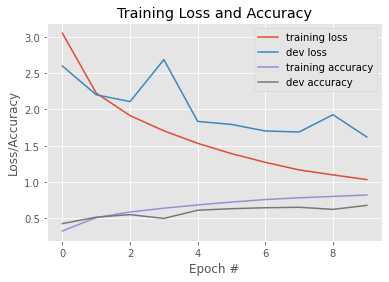

In [ ]:
maxEpochs = 10
batch_size = 32

model = ResNet.build(256, 256, 3, 45, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
H = model.fit(train_dataset, batch_size = batch_size, validation_data = test_dataset, epochs = maxEpochs)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### Transfer Learning using MobileNetV3Small with ImageNet Weights

In [17]:
base_model = keras.applications.MobileNetV3Small(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

4334752/4334752 [==============================] - 1s 0us/step


In [18]:
base_model.trainable = False

In [19]:
inputs = keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=False)
# softmax classifier
x = Flatten()(x)
x = Dense(45)(x)
x = Activation('softmax')(x)
        
# create the model
model = Model(inputs, x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 8, 8, 576)        939120    
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_2 (Dense)             (None, 45)                1658925   
                                                                 
 activation_5 (Activation)   (None, 45)                0         
                                                                 
Total params: 2,598,045
Trainable params: 1,658,925
Non-trainable params: 939,120
_____________________________________________

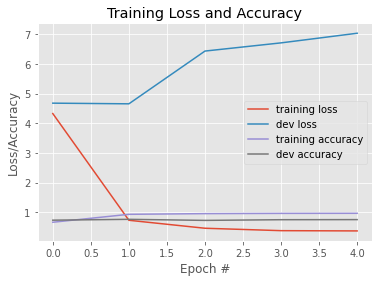

In [20]:
maxEpochs = 5
batch_size = 32

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(model.summary())
H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = maxEpochs, batch_size = batch_size)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [21]:
model.save("model2")

### Basic Ensemble Learning with Two ShallowNets

In [13]:
class ShallowNet:
    # create the architecture
    def build(height, width, depth, numFilters, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with numFilters number of 3x3 filters
        model.add(Conv2D(numFilters, (3, 3), padding='same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

In [14]:
numberOfModels = 2
epochs = 5

for i in range(numberOfModels):
    print('Net', i, 'is being trained...')
    
    # choose the optimizer
    opt = Adam()
    
    # compile the model
    model = ShallowNet.build(256, 256, 3, 3, 45)
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    # train the model
    H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = epochs, batch_size = 32)
    
    # save the model
    model.save("model" + str(i))

    
    # evaluate the network
    predictions = model.predict(testX, batch_size=32)
    report = classification_report(testY,predictions.argmax(axis=1), target_names=feats)
    print(report)    

    

Net 0 is being trained...
Epoch 1/2
591/591 [==============================] - 26s 40ms/step - loss: 134.4830 - accuracy: 0.0692 - val_loss: 8.0929 - val_accuracy: 0.0852
Epoch 2/2
591/591 [==============================] - 22s 37ms/step - loss: 2.1652 - accuracy: 0.5654 - val_loss: 11.2407 - val_accuracy: 0.1049


197/197 [==============================] - 1s 6ms/step
                       precision    recall  f1-score   support

             airplane       0.04      0.02      0.03       140
              airport       0.11      0.14      0.12       132
     baseball_diamond       0.00      0.00      0.00       145
     basketball_court       0.03      0.01      0.02       149
                beach       0.05      0.05      0.05       141
               bridge       0.09      0.04      0.05       133
            chaparral       0.11      0.08      0.09       149
               church       0.06      0.11      0.08       152
    circular_farmland       0.09      0.14      0.11       126
                cloud       0.06      0.07      0.06       137
      commercial_area       0.06      0.06      0.06       151
    dense_residential       0.06      0.11      0.08       140
               desert       0.50      0.65      0.56       143
               forest       0.15      0.27      0.19       131

197/197 [==============================] - 1s 6ms/step
                       precision    recall  f1-score   support

             airplane       0.00      0.00      0.00       140
              airport       0.07      0.17      0.10       132
     baseball_diamond       0.13      0.06      0.08       145
     basketball_court       0.01      0.01      0.01       149
                beach       0.10      0.08      0.09       141
               bridge       0.09      0.02      0.04       133
            chaparral       0.12      0.17      0.14       149
               church       0.07      0.15      0.10       152
    circular_farmland       0.12      0.15      0.13       126
                cloud       0.06      0.09      0.07       137
      commercial_area       0.04      0.02      0.03       151
    dense_residential       0.05      0.06      0.06       140
               desert       0.21      0.87      0.34       143
               forest       0.12      0.45      0.18       131

In [16]:
models = []
model0 = keras.models.load_model("model0")
model1 = keras.models.load_model("model1")
models.append(model0)
models.append(model1)


# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []

# loop over the models
for model in models:
    # use the current model to make predictions on the testing data, then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size=32))

# average the probabilities across all model predictions
predictions = np.average(predictions, axis=0)


# show a classification report
print(classification_report(testY, predictions.argmax(axis=1)))

Evaluating ensemble...
197/197 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.07      0.02      0.03       140
           1       0.10      0.19      0.13       132
           2       0.16      0.06      0.09       145
           3       0.02      0.01      0.02       149
           4       0.06      0.06      0.06       141
           5       0.08      0.02      0.04       133
           6       0.14      0.14      0.14       149
           7       0.07      0.14      0.09       152
           8       0.10      0.15      0.12       126
           9       0.05      0.07      0.06       137
          10       0.07      0.05      0.06       151
          11       0.08      0.14      0.10       140
          12       0.33      0.77      0.46       143
          13       0.15      0.43      0.23       131
          14       0.07      0.04      0.05       128
          15       0.06      0.03      0.04       121
   

### Transfer Learning using Xception Model with ImageNet Weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

In [ ]:
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=False)
# softmax classifier
x = Flatten()(x)
x = Dense(45)(x)
x = Activation('softmax')(x)
        
# create the model
model = Model(inputs, x)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 45)                5898285   
                                                                 
 activation_3 (Activation)   (None, 45)                0         
                                                                 
Total params: 26,759,765
Trainable params: 5,898,285
Non-trainable params: 20,861,480
_________________________________________________________________
None
Epoch 1/5
591/591 [===============

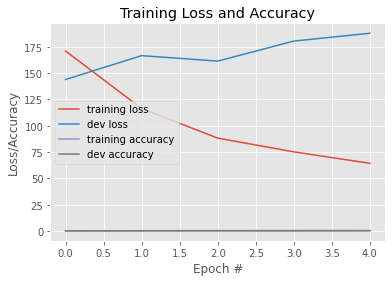

In [ ]:
maxEpochs = 5
batch_size = 32

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(model.summary())
H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = maxEpochs, batch_size = batch_size)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpochs), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpochs), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpochs), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### Ensemble Training using MobileNetV3Small and LeNet

In [24]:
models = []
model1 = keras.models.load_model("model1")
model2 = keras.models.load_model("model2")
models.append(model1)
models.append(model2)


# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []

# loop over the models
for model in models:
    # use the current model to make predictions on the testing data, then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size=32))

# average the probabilities across all model predictions
predictions = np.average(predictions, axis=0)


# show a classification report
print(classification_report(testY, predictions.argmax(axis=1)))

Evaluating ensemble...
197/197 [==============================] - 4s 18ms/step
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.49      0.89      0.63       132
           2       0.80      0.74      0.77       145
           3       0.82      0.60      0.69       149
           4       0.72      0.91      0.81       141
           5       0.96      0.83      0.89       133
           6       0.96      0.94      0.95       149
           7       0.66      0.55      0.60       152
           8       0.96      0.85      0.90       126
           9       0.94      0.91      0.93       137
          10       0.86      0.46      0.60       151
          11       0.46      0.89      0.60       140
          12       0.86      0.83      0.84       143
          13       0.81      0.95      0.87       131
          14       0.49      0.81      0.61       128
          15       0.95      0.73      0.82       121
  

## Model Testing

197/197 [==============================] - 4s 18ms/step

Testing Classification Report:

                        precision    recall  f1-score   support

             airplane       0.81      0.86      0.83       140
              airport       0.48      0.89      0.62       132
     baseball_diamond       0.78      0.74      0.76       145
     basketball_court       0.80      0.60      0.69       149
                beach       0.72      0.93      0.81       141
               bridge       0.96      0.79      0.87       133
            chaparral       0.95      0.94      0.95       149
               church       0.66      0.54      0.59       152
    circular_farmland       0.97      0.85      0.91       126
                cloud       0.93      0.91      0.92       137
      commercial_area       0.87      0.44      0.58       151
    dense_residential       0.43      0.89      0.58       140
               desert       0.86      0.79      0.82       143
               forest      

<Figure size 432x288 with 0 Axes>

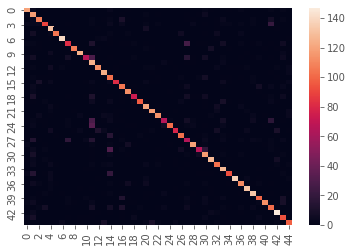

<Figure size 432x288 with 0 Axes>

In [25]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# predict the labels of the test set
predictedY = model.predict(testX)


# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY.argmax(axis=1), target_names=feats))

# predict the labels of the test set
#predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY.argmax(axis = 1)))
plt.figure()

## Conclusions

The RESCISC-45 dataset consisted of 45 classes of satellite images with 700 images in each class. A convolutional neural network was required to efficiently train a model to classify the images.

The simple ShallowNet only included a single 2D convolution layer that implemented a ReLu activation function and a fully-connected layer at the end with a Softmax classifier to predict the classification outputs. This model did not perform very well since it had a very basic convolutional structure, with about a 10% accuracy.

However, more complicated models do not always produce the best accuracies either. For instance, the deeper neural networks, such as MiniGoogLeNet and ResNet, had fairly high accuracies at the beginning of their training, but their accuracy leveled off within a few epochs or even slightly decreased. **Note: The implementation of these blocks remained unmodified when the data loading technique was changed due to the long runtimes.

The semi-deep models such as AlexNet, LeNet, and the SandwichCNN did not learn as quickly as the deeper networks, but with a larger epoch number, these models (LeNet in particular) were able to reach the same level of accuracy as the deeper ones with fewer oscillations in loss and accuracy.

Transfer learning was especially helpful throughout this homework. Since the models were pretrainined on ImageNet, they were ensured to perform well on image classification problems. The second transfer learning run, MobileNetSmallV3, perfomed especially well on this dataset and resulted in a 75% accuracy on the validation set.

When implementing ensemble learning between different models, or multiple runs of the same model, the validation/test accuracy always increased compared to those of the individual models. Since ensemble models essentially vote on the best model result, the accuracies ought to be higher than the individual ones.

The final test performance was at 76% accuracy with an ensemble model including LeNet and MobileNetSmallV3.